# Surprise Housing - Advanced regression assignment

### Problem Statement

A US-based housing company named Surprise Housing has decided to enter the Australian market. The company uses data analytics to purchase houses at a price below their actual values and flip them on at a higher price.
The company is looking at prospective properties to buy to enter the market.

### Objective 

* Determine the significant variables in predicting the price of a house
* How those variables describe the price of a house
* Determine the optimal value of lambda for Ridge and Lasso regression.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Import python libraries for model building
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score


from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

import os

## Step 1 - Read data/Understanding data

In [2]:
# Read the dataset from CSV file and display first five rows
housing = pd.read_csv('https://ml-course3-upgrad.s3.amazonaws.com/Assignment_+Advanced+Regression/train.csv')
housing.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [3]:
# Check the shape of dataset 
housing.shape

(1460, 81)

In [4]:
# Check the info to check for null values 
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [5]:
# Column MSSubClass is actually categorical - Let's convert to categorical
housing['MSSubClass'] = housing['MSSubClass'].astype('str')

Column 'ID' is same as index and can be dropped. 

In [6]:
# Drop the column 'Id'
housing.drop(['Id'],axis=1,inplace=True)
housing.shape

(1460, 80)

## Step - Fill missing Values

There are few NaN values in columns. Let's determine the percentage of NaN.

There missing value percentage is high in case quite few columns and on looking into the data definition these are not actual missing values.
* 'PoolQC'     - NA - Actual value is 'No Pool'
* 'MiscFeature - NA - Actual value is 'None'
* 'Alley'      - NA - Actual value is 'No Alley access'
* 'Fence'      - NA - Actual value is 'No Fence'
* 'FireplaceQu'  - NA - Actual value is 'No Fireplace'
* 'GarageType','GarageFinish','GarageQual','GarageCond'  - NA - Actual value is 'No Garage'
* 'BsmtExposure','BsmtFinType2','BsmtFinType2','BsmtCond','BsmtQual' - NA - Actual value is 'No Basement'

NaNs on the above columns should be replaced accordingly

In [7]:
# Fill NaN's with right values in columns
housing.PoolQC = housing.PoolQC.fillna('No Pool')
housing.MiscFeature = housing.MiscFeature.fillna('None')
housing.Alley = housing.Alley.fillna('No Alley')
housing.Fence = housing.Fence.fillna('No Fence')
housing.FireplaceQu = housing.FireplaceQu.fillna('No Fireplace')

housing[['GarageType','GarageFinish','GarageQual','GarageCond']] = housing[['GarageType','GarageFinish','GarageQual','GarageCond']].fillna('No Garage')
housing[['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']] = housing[['BsmtExposure','BsmtFinType2','BsmtFinType1','BsmtCond','BsmtQual']].fillna('No Basement')

* Electrical, MasVnrType, MasVnrArea missing values are less than 1%. We can impute them with mode
* LotFrontage is numerical data and 259 rows has missing values. Let's impute with mean

In [8]:
# Fill the other missing columns with mode.
housing.Electrical = housing.Electrical.fillna('SBrkr')
housing.MasVnrType = housing.MasVnrType.fillna('None')
housing.MasVnrArea = housing.MasVnrArea.fillna(0)

In [9]:
# Impute 'LotFrontage' with mean value
housing.LotFrontage = housing.LotFrontage.fillna(housing.LotFrontage.mean())
housing.LotFrontage = pd.to_numeric(housing.LotFrontage,errors='coerce')

* TotalBsmtSF is sufficient to describe the total basement area. The other columns 'BsmtFinSF1' and 'BsmtUnfSF' can be dropped as well
* 'GrLivArea' is total of '1stFlrSF' and '2ndFlrSF' - Let's drop these two columns

In [10]:
# Drop columns 
housing.drop(['BsmtFinSF2','BsmtUnfSF','BsmtFinSF1','1stFlrSF','2ndFlrSF'],axis=1,inplace=True)

In [11]:
# View the shape of dataset after dropping columns
housing.shape

(1460, 75)

## Data Preparation

In [12]:
# Unicode column - CentralAir
housing.CentralAir = housing.CentralAir.map({'N':0,'Y':1})

In [13]:
# Map into Catergorical data for easier interpretation.
housing.OverallQual = housing.OverallQual.map({10:'VExcellent',9:'Excellent',8:'VGood',7:'Good',6:'Abv Aver',5:'Average',4:'Below Aver',3:'Fair',2:'Poor',1:'VPoor'})
housing.OverallCond = housing.OverallCond.map({10:'VExcellent',9:'Excellent',8:'VGood',7:'Good',6:'Abv Aver',5:'Average',4:'Below Aver',3:'Fair',2:'Poor',1:'VPoor'})
housing.MoSold = housing.MoSold.map({1:'Jan',2:'Feb',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'})

In [14]:
# View distribution of the numeric variables.
housing.describe()

LotFrontage        LotArea    YearBuilt  YearRemodAdd   MasVnrArea  \
count  1460.000000    1460.000000  1460.000000   1460.000000  1460.000000   
mean     70.049958   10516.828082  1971.267808   1984.865753   103.117123   
std      22.024023    9981.264932    30.202904     20.645407   180.731373   
min      21.000000    1300.000000  1872.000000   1950.000000     0.000000   
25%      60.000000    7553.500000  1954.000000   1967.000000     0.000000   
50%      70.049958    9478.500000  1973.000000   1994.000000     0.000000   
75%      79.000000   11601.500000  2000.000000   2004.000000   164.250000   
max     313.000000  215245.000000  2010.000000   2010.000000  1600.000000   

       TotalBsmtSF   CentralAir  LowQualFinSF    GrLivArea  BsmtFullBath  ...  \
count  1460.000000  1460.000000   1460.000000  1460.000000   1460.000000  ...   
mean   1057.429452     0.934932      5.844521  1515.463699      0.425342  ...   
std     438.705324     0.246731     48.623081   525.480383      0.518911  ...   
min       0.000000     0.000000      0.000000   334.000000      0.000000  ...   
25%     795.750000     1.000000      0.000000  1129.500000      0.000000  ...   
50%     991.500000     1.000000      0.000000  1464.000000      0.000000  ...   
75%    1298.250000     1.000000      0.000000  1776.750000      1.000000  ...   
max    6110.000000     1.000000    572.000000  5642.000000      3.000000  ...   

        GarageArea   WoodDeckSF  OpenPorchSF  EnclosedPorch    3SsnPorch  \
count  1460.000000  1460.000000  1460.000000    1460.000000  1460.000000   
mean    472.980137    94.244521    46.660274      21.954110     3.409589   
std     213.804841   125.338794    66.256028      61.119149    29.317331   
min       0.000000     0.000000     0.000000       0.000000     0.000000   
25%     334.500000     0.000000     0.000000       0.000000     0.000000   
50%     480.000000     0.000000    25.000000       0.000000     0.000000   
75%     576.000000   168.000000    68.000000       0.000000     0.000000   
max    1418.000000   857.000000   547.000000     552.000000   508.000000   

       ScreenPorch     PoolArea       MiscVal       YrSold      SalePrice  
count  1460.000000  1460.000000   1460.000000  1460.000000    1460.000000  
mean     15.060959     2.758904     43.489041  2007.815753  180921.195890  
std      55.757415    40.177307    496.123024     1.328095   79442.502883  
min       0.000000     0.000000      0.000000  2006.000000   34900.000000  
25%       0.000000     0.000000      0.000000  2007.000000  129975.000000  
50%       0.000000     0.000000      0.000000  2008.000000  163000.000000  
75%       0.000000     0.000000      0.000000  2009.000000  214000.000000  
max     480.000000   738.000000  15500.000000  2010.000000  755000.000000  

[8 rows x 29 columns]

### Outlier removal

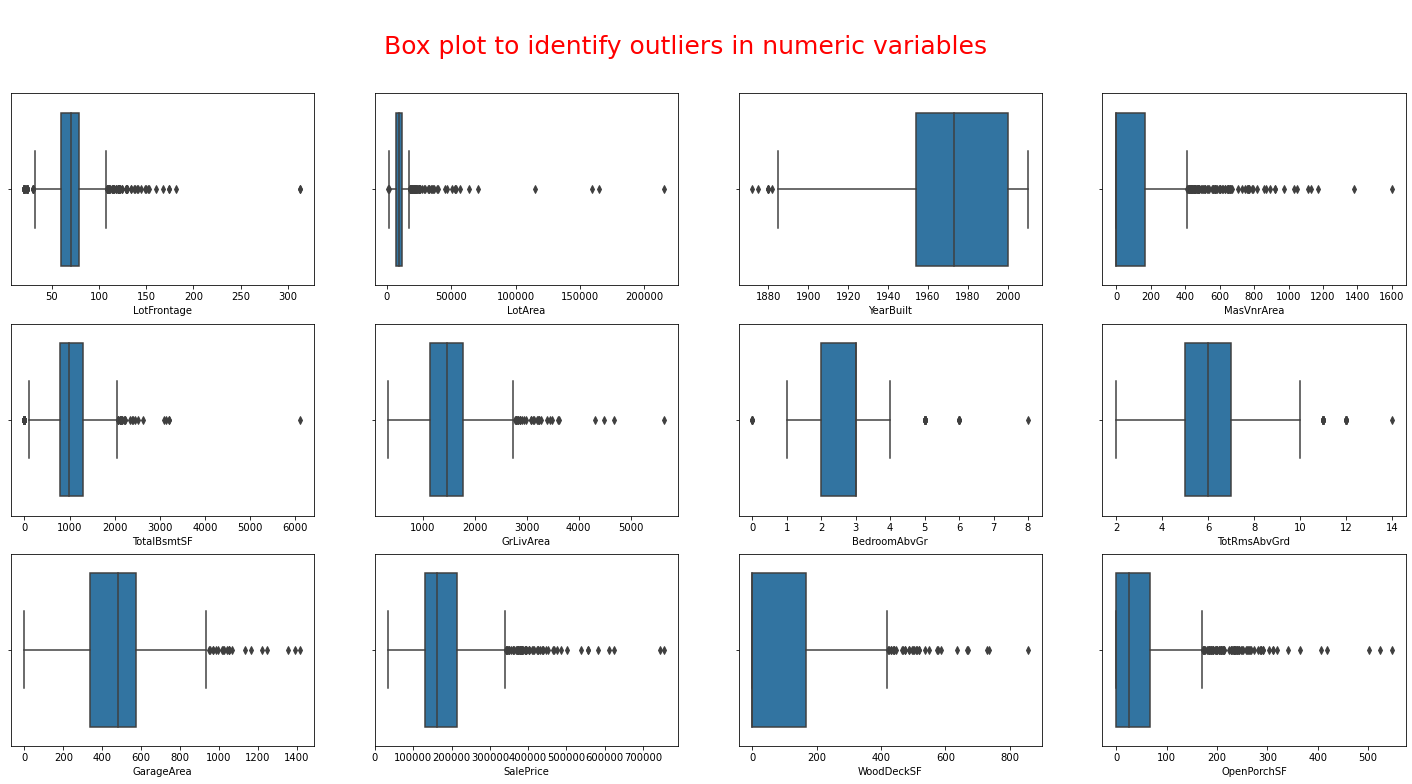

In [15]:
# On looking into the describe for the dataframe, quite few columns has outliers. Let's plot a box plot for those.
# Create box plots for the columns and look for outliers

fig = plt.figure(figsize=(25,12))
fig.suptitle('\nBox plot to identify outliers in numeric variables',fontsize=25,color='r')

plt.subplot(3,4,1)
sns.boxplot(housing.LotFrontage)

plt.subplot(3,4,2)
sns.boxplot(housing.LotArea)

plt.subplot(3,4,3)
sns.boxplot(housing.YearBuilt)

plt.subplot(3,4,4)
sns.boxplot(housing.MasVnrArea)

plt.subplot(3,4,5)
sns.boxplot(housing.TotalBsmtSF)

plt.subplot(3,4,6)
sns.boxplot(housing.GrLivArea)

plt.subplot(3,4,7)
sns.boxplot(housing.BedroomAbvGr)

plt.subplot(3,4,8)
sns.boxplot(housing.TotRmsAbvGrd)

plt.subplot(3,4,9)
sns.boxplot(housing.GarageArea)

plt.subplot(3,4,10)
sns.boxplot(housing.SalePrice)

plt.subplot(3,4,11)
sns.boxplot(housing.WoodDeckSF)

plt.subplot(3,4,12)
sns.boxplot(housing.OpenPorchSF)

plt.show()

In [16]:
# Define function to determine the IQR and upper, lower limit.
def find_outlier(x):
    Q1 = np.percentile(x,25,interpolation = 'midpoint')
    Q3 = np.percentile(x,75,interpolation = 'midpoint')
    IQR = Q3 - Q1

    lower = Q1 - 1.5 * IQR 
    upper = Q3 + 1.5 * IQR
    
    print (Q1,Q3, IQR, lower, upper)
    return x

In [17]:
# Apply find outlier functions on the columns
housing.LotArea      = find_outlier(housing.LotArea)
housing.LotFrontage  = find_outlier(housing.LotFrontage)
housing.YearBuilt    = find_outlier(housing.YearBuilt)
housing.MasVnrArea   = find_outlier(housing.MasVnrArea)
housing.TotalBsmtSF  = find_outlier(housing.TotalBsmtSF)
housing.GrLivArea    = find_outlier(housing.GrLivArea)
housing.BedroomAbvGr = find_outlier(housing.BedroomAbvGr)
housing.TotRmsAbvGrd = find_outlier(housing.TotRmsAbvGrd)
housing.GarageArea   = find_outlier(housing.GarageArea)
housing.SalePrice    = find_outlier(housing.SalePrice)
housing.WoodDeckSF   = find_outlier(housing.WoodDeckSF)
housing.OpenPorchSF  = find_outlier(housing.OpenPorchSF)

7549.0 11603.0 4054.0 1468.0 17684.0
60.0 79.0 19.0 31.5 107.5
1954.0 2000.0 46.0 1885.0 2069.0
0.0 164.5 164.5 -246.75 411.25
795.5 1298.5 503.0 41.0 2053.0
1129.0 1777.5 648.5 156.25 2750.25
2.0 3.0 1.0 0.5 4.5
5.0 7.0 2.0 2.0 10.0
333.0 576.0 243.0 -31.5 940.5
129950.0 214000.0 84050.0 3875.0 340075.0
0.0 168.0 168.0 -252.0 420.0
0.0 68.0 68.0 -102.0 170.0


In [18]:
#List Outliers from the columns
housing.LotArea      = housing.LotArea[housing.LotArea < 17684]
housing.LotArea      = housing.LotArea[housing.LotArea > 1468]

housing.LotFrontage  = housing.LotFrontage[housing.LotFrontage < 107.5] 
housing.LotFrontage  = housing.LotFrontage[housing.LotFrontage > 31.5]

housing.YearBuilt    = housing.YearBuilt[housing.YearBuilt < 2069]
housing.YearBuilt    = housing.YearBuilt[housing.YearBuilt > 1885]

housing.MasVnrArea   = housing.MasVnrArea[housing.MasVnrArea < 411.25]
housing.MasVnrArea   = housing.MasVnrArea[housing.MasVnrArea > 75]

housing.TotalBsmtSF  = housing.TotalBsmtSF[housing.TotalBsmtSF < 2053]
housing.TotalBsmtSF  = housing.TotalBsmtSF[housing.TotalBsmtSF > 41]

housing.GrLivArea    = housing.GrLivArea[housing.GrLivArea < 2750.25]
housing.GrLivArea    = housing.GrLivArea[housing.GrLivArea > 156.25]

housing.BedroomAbvGr = housing.BedroomAbvGr[housing.BedroomAbvGr < 4] 
housing.BedroomAbvGr = housing.BedroomAbvGr[housing.BedroomAbvGr > 0]

housing.TotRmsAbvGrd = housing.TotRmsAbvGrd[housing.TotRmsAbvGrd < 7]
housing.TotRmsAbvGrd = housing.TotRmsAbvGrd[housing.TotRmsAbvGrd > 2]

housing.GarageArea   = housing.GarageArea[housing.GarageArea < 940.5]
housing.GarageArea   = housing.GarageArea[housing.GarageArea > -31.5]

housing.SalePrice    = housing.SalePrice[housing.SalePrice < 340075]
housing.SalePrice    = housing.SalePrice[housing.SalePrice > 3875]
 
housing.WoodDeckSF   = housing.WoodDeckSF[housing.WoodDeckSF < 420]
housing.WoodDeckSF   = housing.WoodDeckSF[housing.WoodDeckSF > -252]
 
housing.OpenPorchSF  = housing.OpenPorchSF[housing.OpenPorchSF < 170]
housing.OpenPorchSF  = housing.OpenPorchSF[housing.OpenPorchSF > -102]

In [19]:
# Check for nulls after outlier identification
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   object 
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1354 non-null   float64
 3   LotArea        1392 non-null   float64
 4   Street         1460 non-null   object 
 5   Alley          1460 non-null   object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   object 
 17  OverallCond    1460 non-null   object 
 18  YearBuil

In [20]:
# Remove outliers from the other columns in the dataframe
housing = housing[(housing.GarageArea < 940.5) & (housing.GarageArea > -31.5)]
housing = housing[(housing.WoodDeckSF < 420) & (housing.WoodDeckSF > -252)]
housing = housing[(housing.SalePrice < 340075) & (housing.SalePrice > 3875)]
housing = housing[(housing.LotArea < 17684) & (housing.LotArea > 1468)]
housing = housing[(housing.LotFrontage < 107.5) & (housing.LotFrontage > 31.5)]
housing = housing[(housing.YearBuilt < 2069) & (housing.YearBuilt > 1885)]

In [21]:
# See the shape of the dataframe.
housing.shape

(1222, 75)

In [22]:
# Impute the dataframe with mean, mode values after outlier removal 
housing.TotalBsmtSF = housing.TotalBsmtSF.fillna(housing.TotalBsmtSF.mean())
housing.BedroomAbvGr = housing.BedroomAbvGr.fillna(housing.BedroomAbvGr.mode()[0])
housing.GarageYrBlt = housing.GarageYrBlt.fillna(housing.GarageYrBlt.mode()[0])
housing.OpenPorchSF = housing.OpenPorchSF.fillna(housing.OpenPorchSF.mean())
housing.GrLivArea = housing.GrLivArea.fillna(housing.GrLivArea.mean())
housing.MasVnrArea = housing.MasVnrArea.fillna(housing.MasVnrArea.mean())
housing.TotRmsAbvGrd = housing.TotRmsAbvGrd.fillna(housing.TotRmsAbvGrd.mode()[0])

In [23]:
# check for null values in the final dataframe
null_value_count = housing.isna().sum() 
null_value_count = null_value_count[null_value_count > 0] * 100 / len(housing)
null_value_count.sort_values(ascending=False)

Series([], dtype: float64)

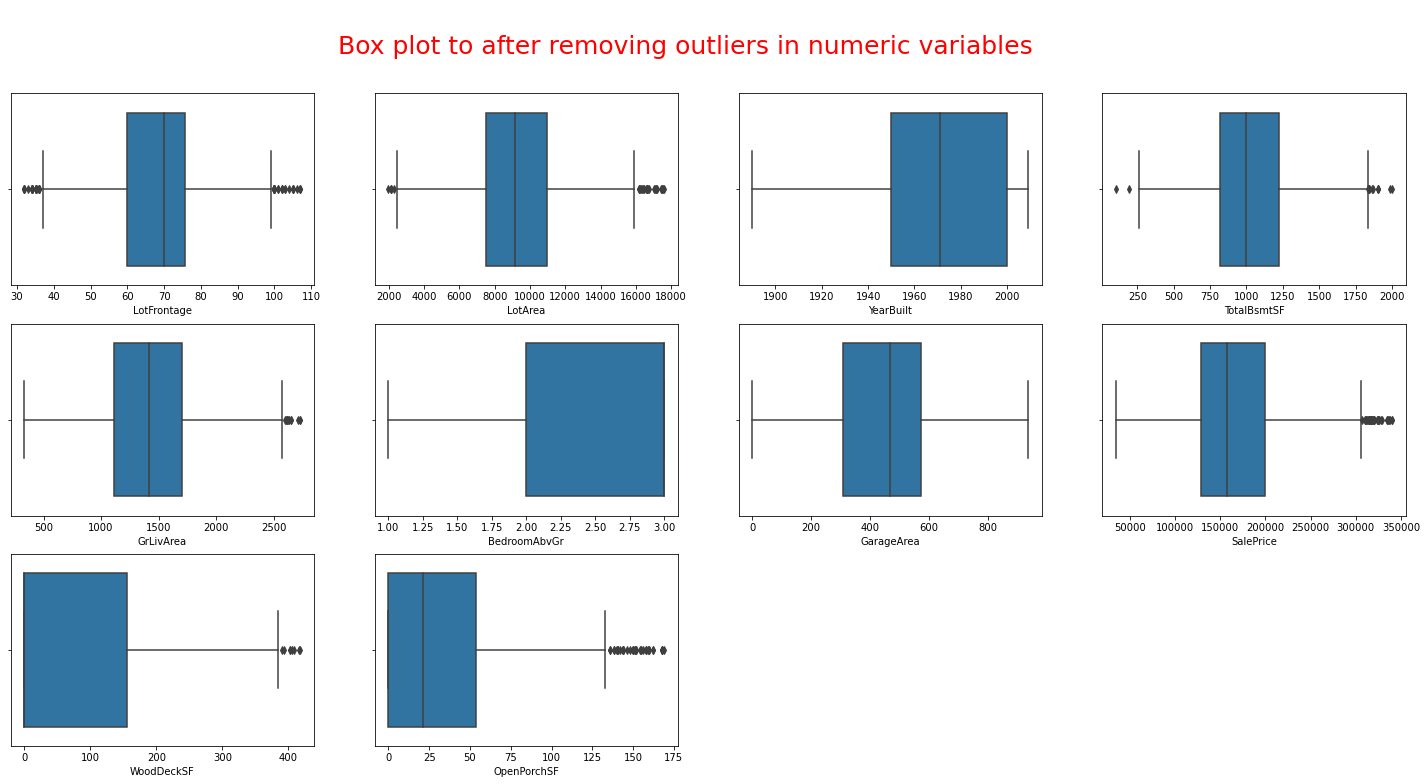

In [24]:
# On looking into the describe for the dataframe, quite few columns has outliers. Let's plot a box plot for those.
# Create box plots for the columns and look for outliers

fig = plt.figure(figsize=(25,12))
fig.suptitle('\nBox plot to after removing outliers in numeric variables',fontsize=25,color='r')

plt.subplot(3,4,1)
sns.boxplot(housing.LotFrontage)

plt.subplot(3,4,2)
sns.boxplot(housing.LotArea)

plt.subplot(3,4,3)
sns.boxplot(housing.YearBuilt)

plt.subplot(3,4,4)
sns.boxplot(housing.TotalBsmtSF)

plt.subplot(3,4,5)
sns.boxplot(housing.GrLivArea)

plt.subplot(3,4,6)
sns.boxplot(housing.BedroomAbvGr)

plt.subplot(3,4,7)
sns.boxplot(housing.GarageArea)

plt.subplot(3,4,8)
sns.boxplot(housing.SalePrice)

plt.subplot(3,4,9)
sns.boxplot(housing.WoodDeckSF)

plt.subplot(3,4,10)
sns.boxplot(housing.OpenPorchSF)

plt.show()

* Insights - Most of the outliers have been removed from the numeric columns.

## Data Visualization

Datatypes of the columns look good. Let's proceed to visualize the data

### Univariate Analysis

Visualize numerical data distribution

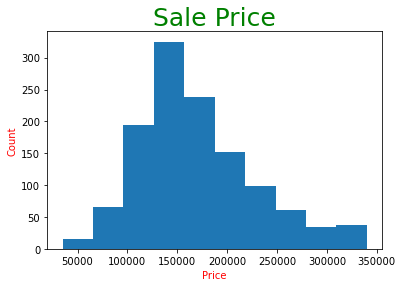

In [25]:
# Plot Sale price to see the distribution
plt.title('Sale Price',fontsize=25,color='g')
plt.hist(housing.SalePrice,bins=10)
plt.xlabel('Price',color='r')
plt.ylabel('Count',color='r')
plt.show()

* Insights - Number of houses that were sold between 100000 and 170000 is higher

Text(0, 0.5, 'Count')

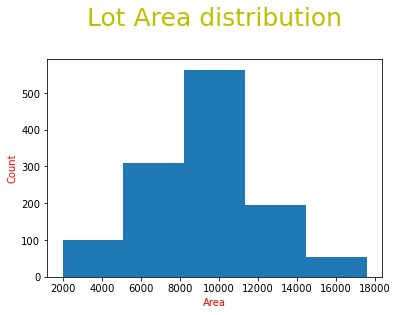

In [26]:
#Plot how the LotArea is distributed
plt.title('Lot Area distribution\n',fontsize=25,color='y')
plt.hist(housing.LotArea,bins=5)
plt.xlabel('Area',color='r')
plt.ylabel('Count',color='r')

* Insights - Number of houses with LotArea around 8K to 11K is high

Text(0, 0.5, 'Count')

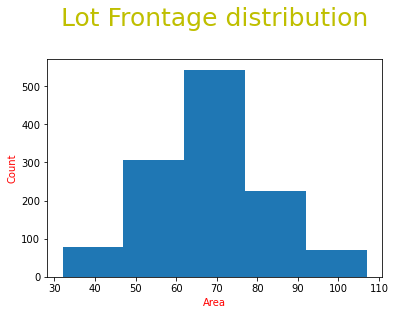

In [27]:
#Plot how the LotFrontage is distributed
plt.title('Lot Frontage distribution\n',fontsize=25,color='y')
plt.hist(housing.LotFrontage,bins=5)
plt.xlabel('Area',color='r')
plt.ylabel('Count',color='r')

* Insights - Number of houses with LotFrontage around 65 to 75

Text(0, 0.5, 'Count')

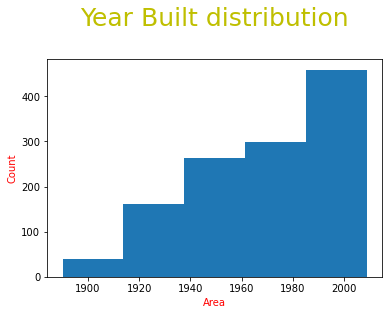

In [28]:
#Plot how the YearBuilt is distributed
plt.title('Year Built distribution\n',fontsize=25,color='y')
plt.hist(housing.YearBuilt,bins=5)
plt.xlabel('Area',color='r')
plt.ylabel('Count',color='r')

* Insights - Number of houses built every decade gradually increases

Text(0, 0.5, 'Count')

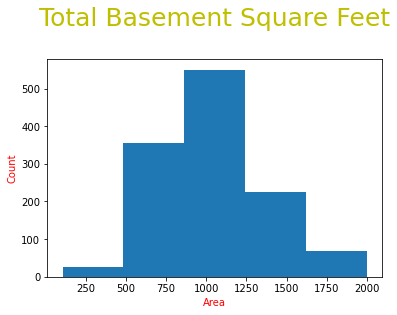

In [29]:
#Plot how the TotalBsmtSF is distributed
plt.title('Total Basement Square Feet\n',fontsize=25,color='y')
plt.hist(housing.TotalBsmtSF,bins=5)
plt.xlabel('Area',color='r')
plt.ylabel('Count',color='r')

* Insights - Number of houses with basement is higher around 800 - 1250 SF

Text(0, 0.5, 'Count')

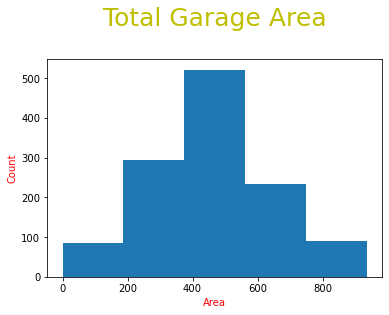

In [30]:
#Plot how the GarageArea is distributed
plt.title('Total Garage Area\n',fontsize=25,color='y')
plt.hist(housing.GarageArea,bins=5)
plt.xlabel('Area',color='r')
plt.ylabel('Count',color='r')

* Insights - Number of houses with garage area around 400 - 600 SF is higher

Text(0, 0.5, 'Count')

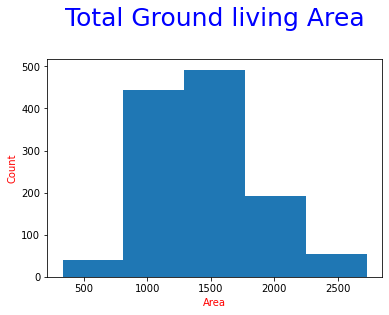

In [31]:
#Plot how the GrLivArea is distributed
plt.title('Total Ground living Area\n',fontsize=25,color='b')
plt.hist(housing.GrLivArea,bins=5)
plt.xlabel('Area',color='r')
plt.ylabel('Count',color='r')

* Insights - There are lesser number of houses where the total living area is less that 500SF or greater than 2000 SF

#### Segmented Univariate 

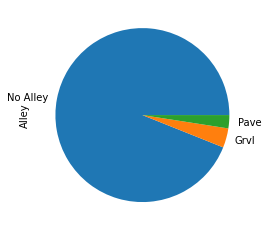

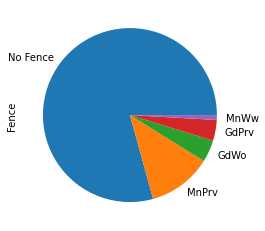

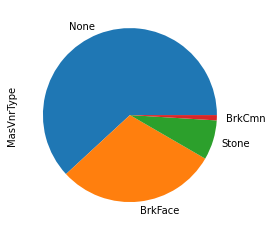

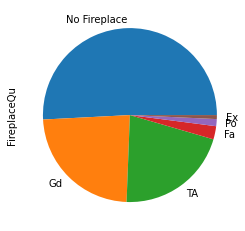

In [32]:
# Have a view how the Alley is distributed.
housing.Alley.value_counts().plot.pie()
plt.show()

# Have a view how the Fence is distributed.
housing.Fence.value_counts().plot.pie()
plt.show()

# Have a view how the MasVnrType is distributed.
housing.MasVnrType.value_counts().plot.pie()
plt.show()

# Have a view how the FirePlace is distributed.
housing.FireplaceQu.value_counts().plot.pie()
plt.show()

* Insights - Most homes have No Alley, No Fence, No fireplace and no MasVnrType

#### Bivariate Analysis

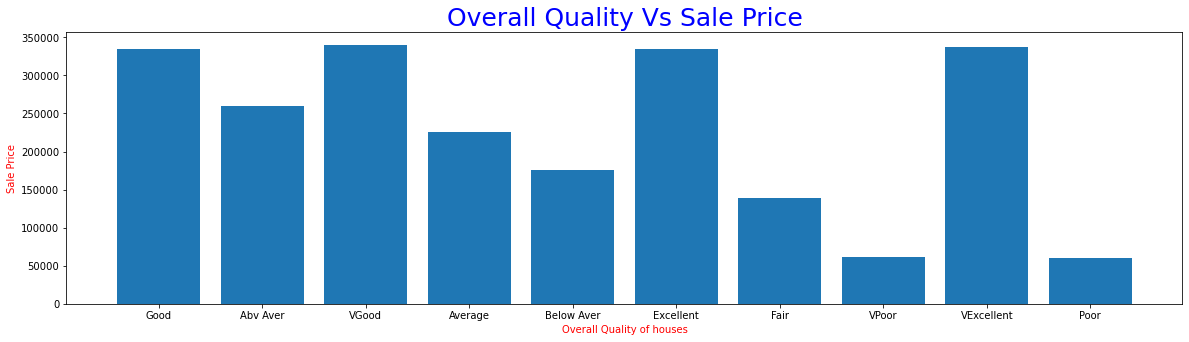

In [33]:
# Have a view how the Sale Price and Overall Quality of the house is related. 
plt.figure(figsize=(20,5))
plt.title('Overall Quality Vs Sale Price',fontsize=25,color='b')
plt.bar(housing.OverallQual,housing.SalePrice)
plt.xlabel('Overall Quality of houses',color='r')
plt.ylabel('Sale Price',color='r')
plt.show()

* Insights - Sale price for homes with overall quality in Very Excellent, Excellent, Very Good, Good are around the same 

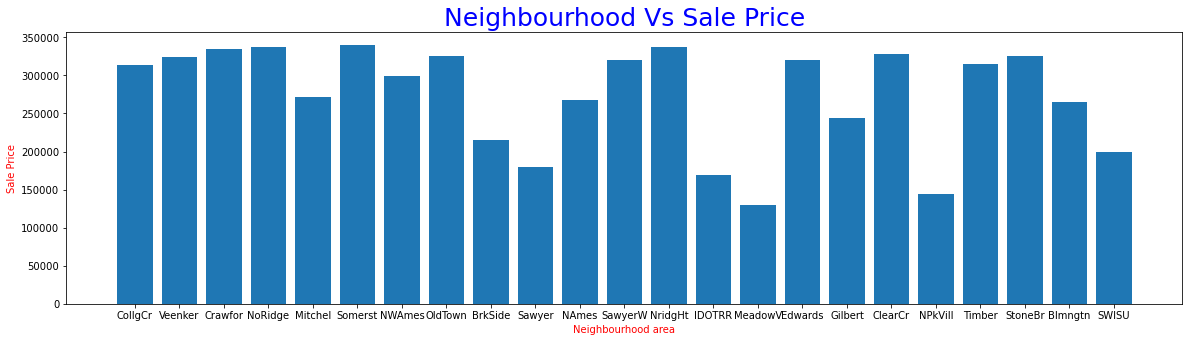

In [34]:
# Have a view how the Sale Price and Neighborhood of the house is related. 
plt.figure(figsize=(20,5))
plt.title('Neighbourhood Vs Sale Price',fontsize=25,color='b')
plt.bar(housing.Neighborhood,housing.SalePrice)
plt.xlabel('Neighbourhood area',color='r')
plt.ylabel('Sale Price',color='r')
plt.show()

* Insights - Sale price is low in Meadow neighbourhood.

<Figure size 1440x2880 with 0 Axes>

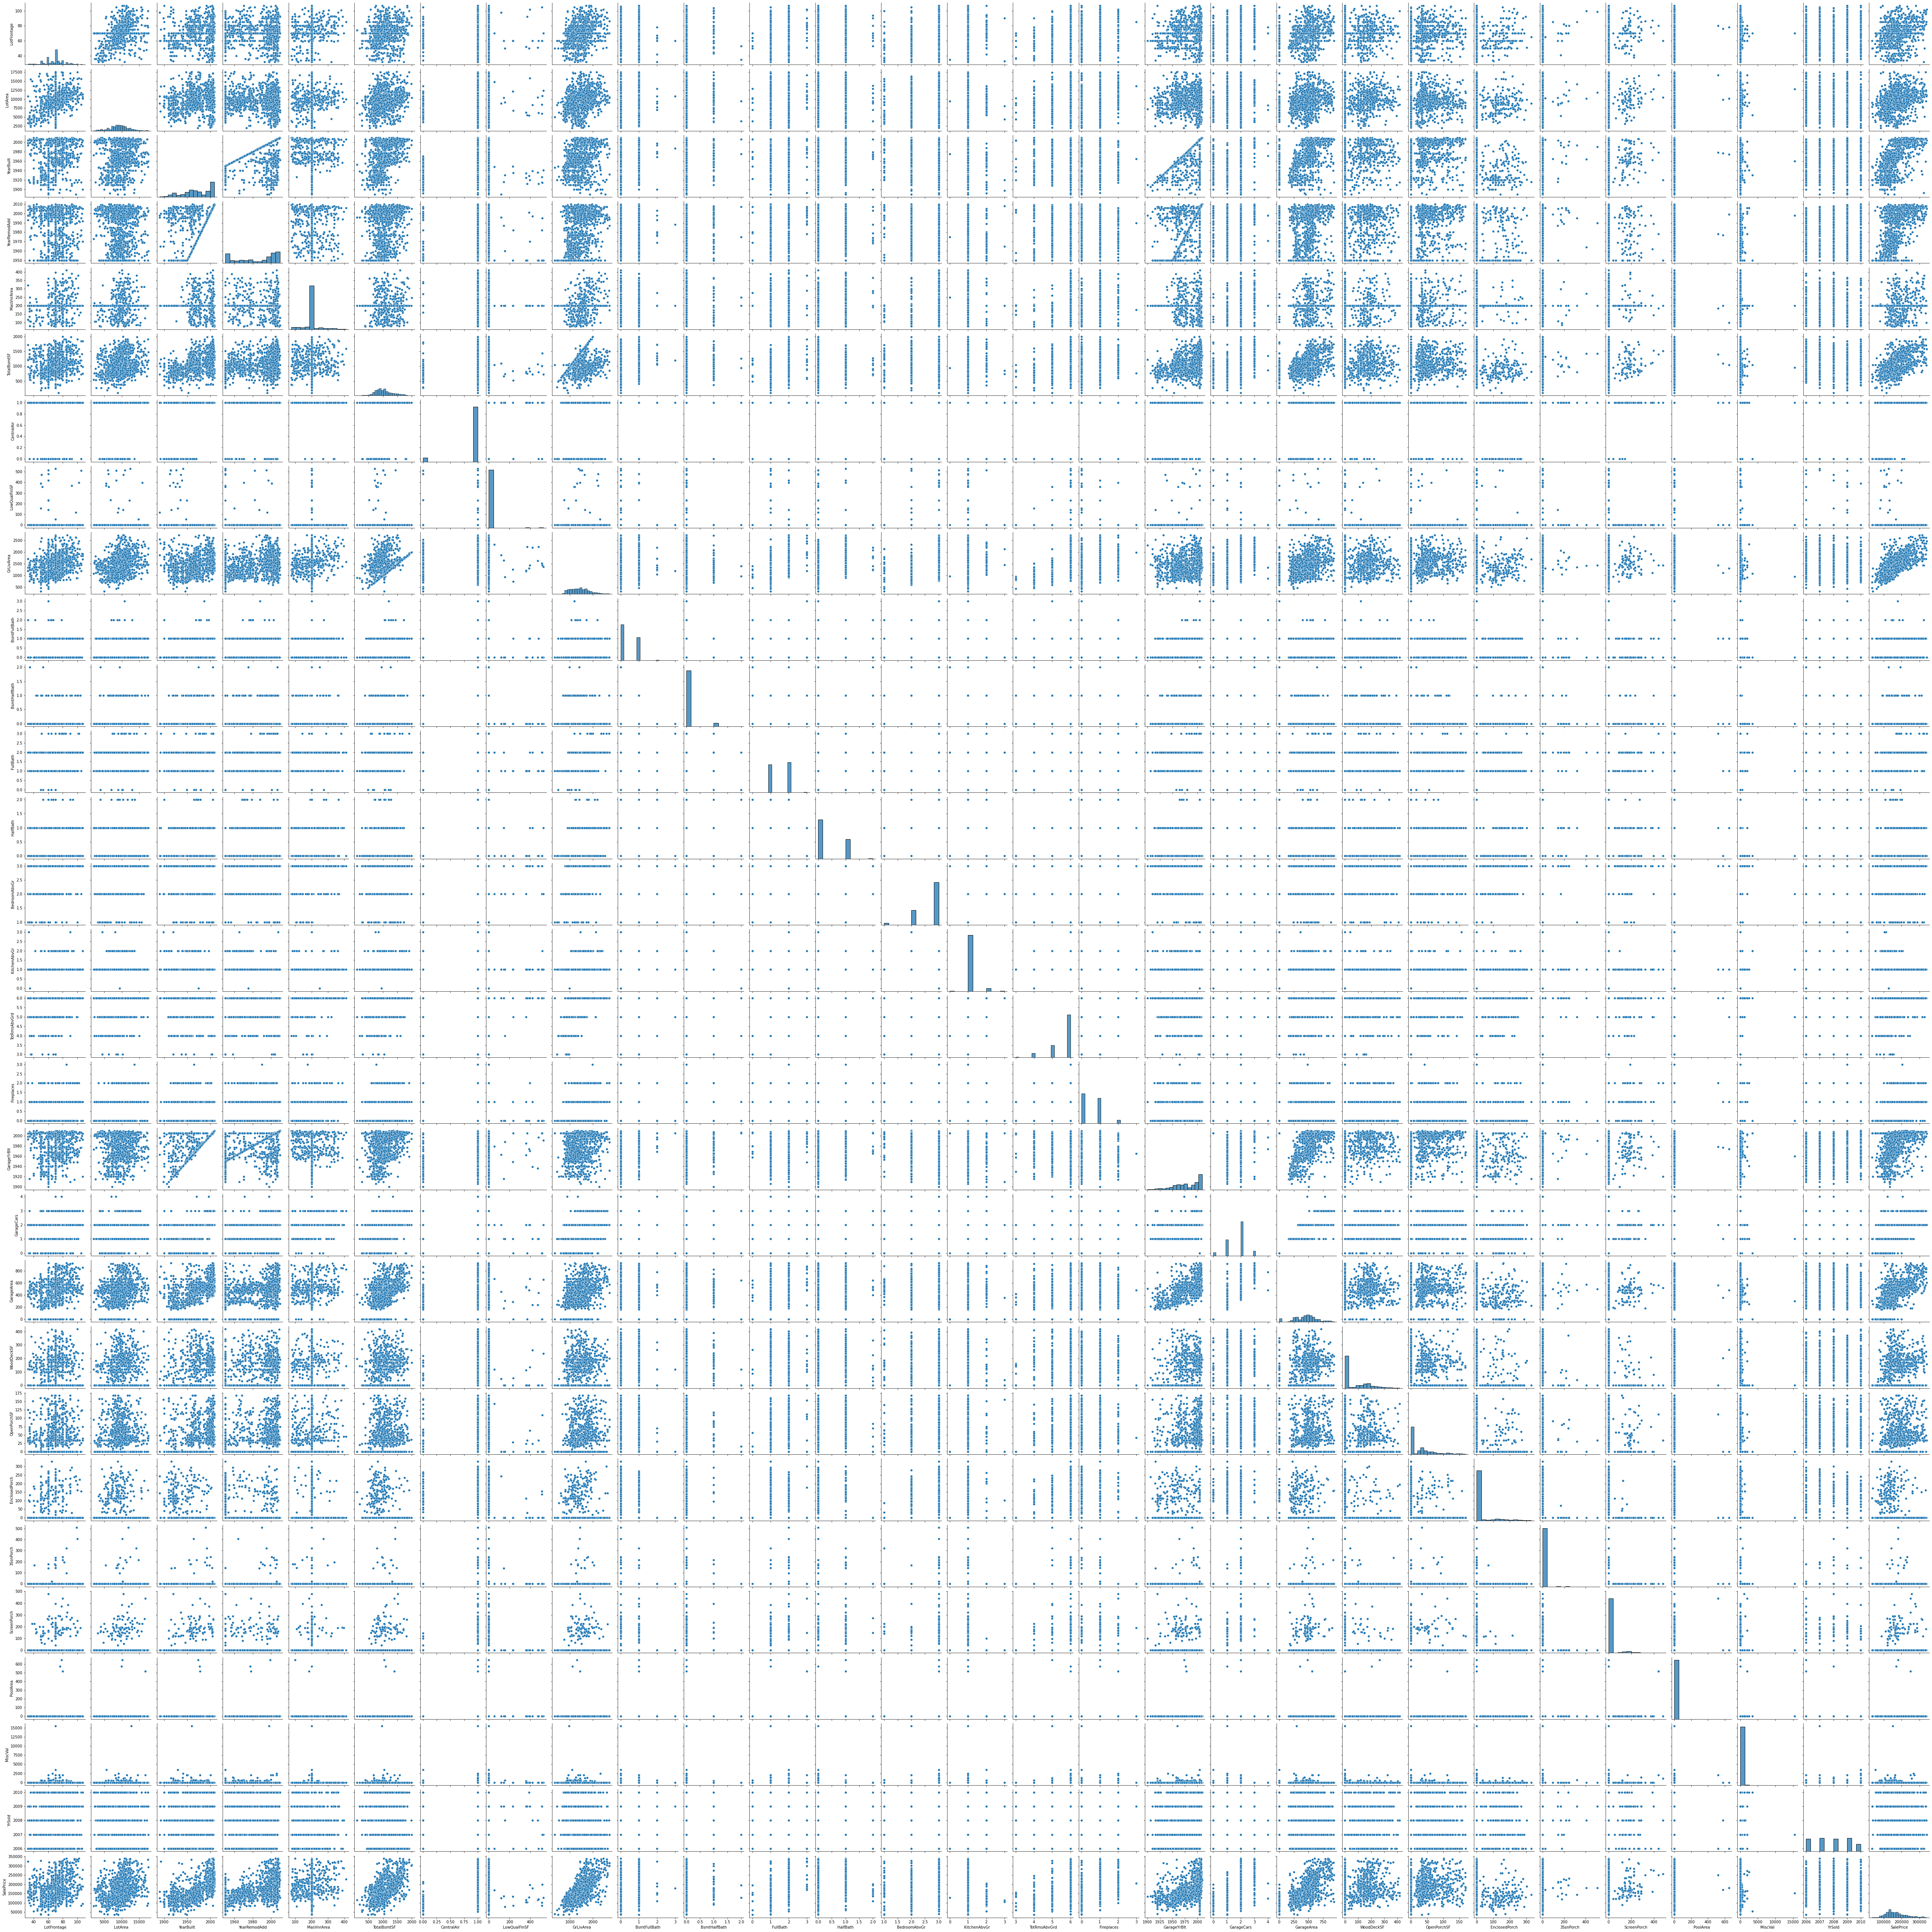

In [35]:
# Visualize the numeric variables using pairplots.
plt.figure(figsize=(20,40))
sns.pairplot(housing)
plt.show()

* Insights - The numeric variables are large and is not visually much helpful to read the data. Let's try and build a correlation table to find the correlation between numeric variables

In [36]:
housing['Age'] = housing['YrSold'] - housing['YearBuilt']
housing.drop(['YrSold', 'YearBuilt'], axis=1, inplace=True)

In [37]:
# Select only numeric variables
numeric_housing = housing.select_dtypes(include=['float64','int64'])
numeric_housing.head()

LotFrontage  LotArea  YearRemodAdd  MasVnrArea  TotalBsmtSF  CentralAir  \
0         65.0   8450.0          2003  196.000000        856.0           1   
1         80.0   9600.0          1976  199.971347       1262.0           1   
2         68.0  11250.0          2002  162.000000        920.0           1   
3         60.0   9550.0          1970  199.971347        756.0           1   
4         84.0  14260.0          2000  350.000000       1145.0           1   

   LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  ...  GarageArea  \
0             0     1710.0             1             0  ...       548.0   
1             0     1262.0             0             1  ...       460.0   
2             0     1786.0             1             0  ...       608.0   
3             0     1717.0             1             0  ...       642.0   
4             0     2198.0             1             0  ...       836.0   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0         0.0         61.0              0          0            0         0   
1       298.0          0.0              0          0            0         0   
2         0.0         42.0              0          0            0         0   
3         0.0         35.0            272          0            0         0   
4       192.0         84.0              0          0            0         0   

   MiscVal  SalePrice   Age  
0        0   208500.0   5.0  
1        0   181500.0  31.0  
2        0   223500.0   7.0  
3        0   140000.0  91.0  
4        0   250000.0   8.0  

[5 rows x 28 columns]

In [38]:
numeric_housing.corr()

LotFrontage   LotArea  YearRemodAdd    MasVnrArea  TotalBsmtSF  \
LotFrontage       1.000000  0.498757      0.040919  1.557915e-01     0.224744   
LotArea           0.498757  1.000000      0.015266  1.073090e-01     0.234997   
YearRemodAdd      0.040919  0.015266      1.000000 -3.957947e-02     0.248789   
MasVnrArea        0.155791  0.107309     -0.039579  1.000000e+00     0.056369   
TotalBsmtSF       0.224744  0.234997      0.248789  5.636912e-02     1.000000   
CentralAir        0.107714  0.095875      0.318158 -2.185890e-02     0.165344   
LowQualFinSF     -0.006947 -0.017540     -0.090474  8.839583e-17    -0.051131   
GrLivArea         0.299214  0.328774      0.266691  2.011557e-01     0.275119   
BsmtFullBath      0.028930  0.064808      0.128110 -6.096363e-02     0.226126   
BsmtHalfBath     -0.000724  0.049337      0.000417 -1.914668e-02    -0.011993   
FullBath          0.162918  0.167089      0.430667  6.014515e-02     0.345602   
HalfBath          0.138469  0.156991      0.181270  1.326182e-01    -0.193442   
BedroomAbvGr      0.340208  0.347853      0.019777  8.696953e-02     0.037953   
KitchenAbvGr      0.007081 -0.030686     -0.143389  3.044121e-02     0.070875   
TotRmsAbvGrd      0.269718  0.300196      0.134565  7.763662e-02     0.218608   
Fireplaces        0.151933  0.241522      0.083402  1.616864e-01     0.212441   
GarageYrBlt       0.043080 -0.018319      0.561694 -3.724703e-02     0.279617   
GarageCars        0.254421  0.213535      0.400665  9.882630e-02     0.394598   
GarageArea        0.280265  0.250741      0.355319  1.048675e-01     0.420293   
WoodDeckSF        0.093474  0.140791      0.240337 -5.873947e-03     0.164044   
OpenPorchSF       0.104969  0.081660      0.295988  3.000008e-02     0.183471   
EnclosedPorch    -0.052699 -0.055361     -0.208772  1.233906e-02    -0.158690   
3SsnPorch         0.079143  0.053313      0.037626  1.400512e-03     0.035183   
ScreenPorch       0.056924  0.098533     -0.049187  4.003024e-02     0.069710   
PoolArea          0.033965  0.047432      0.003502 -4.678997e-02     0.019587   
MiscVal           0.010954  0.049491     -0.002372 -8.324478e-05    -0.011133   
SalePrice         0.316731  0.340110      0.559000  1.450299e-01     0.545337   
Age              -0.159700 -0.091041     -0.600900  2.122122e-02    -0.431286   

               CentralAir  LowQualFinSF  GrLivArea  BsmtFullBath  \
LotFrontage      0.107714 -6.946618e-03   0.299214      0.028930   
LotArea          0.095875 -1.753985e-02   0.328774      0.064808   
YearRemodAdd     0.318158 -9.047387e-02   0.266691      0.128110   
MasVnrArea      -0.021859  8.839583e-17   0.201156     -0.060964   
TotalBsmtSF      0.165344 -5.113126e-02   0.275119      0.226126   
CentralAir       1.000000 -5.516471e-02   0.085091      0.117603   
LowQualFinSF    -0.055165  1.000000e+00   0.033602     -0.036077   
GrLivArea        0.085091  3.360217e-02   1.000000     -0.039989   
BsmtFullBath     0.117603 -3.607722e-02  -0.039989      1.000000   
BsmtHalfBath     0.040494 -2.728061e-02  -0.030918     -0.153029   
FullBath         0.092476 -4.245752e-02   0.602471     -0.073167   
HalfBath         0.129167 -2.501966e-02   0.467615     -0.030867   
BedroomAbvGr     0.118164 -9.312060e-04   0.403188     -0.084249   
KitchenAbvGr    -0.269868  1.484967e-02   0.133512     -0.037571   
TotRmsAbvGrd     0.085874  3.825027e-02   0.567475     -0.067383   
Fireplaces       0.181448 -4.732903e-02   0.403587      0.060509   
GarageYrBlt      0.213812  5.449313e-03   0.167868      0.116501   
GarageCars       0.251746 -1.084448e-01   0.421936      0.102601   
GarageArea       0.254983 -9.043187e-02   0.396919      0.143779   
WoodDeckSF       0.172488 -2.563395e-02   0.154494      0.163117   
OpenPorchSF      0.089995 -2.861262e-02   0.302028      0.039910   
EnclosedPorch   -0.161188  2.690570e-02  -0.027610     -0.066461   
3SsnPorch        0.028891  1.134989e-03   0.020917     -0.024847   
ScreenPorch      0.051168 -3.0306

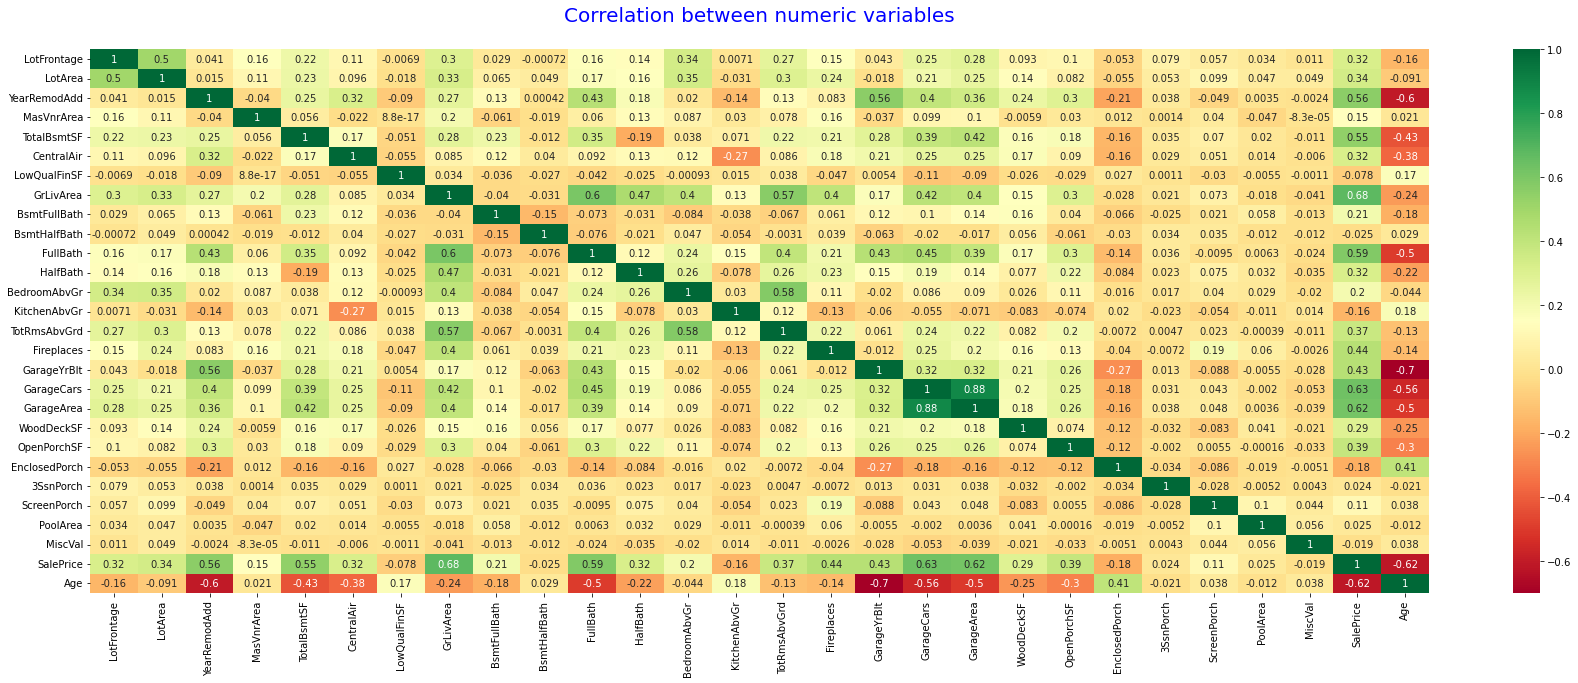

In [39]:
plt.figure(figsize=[30,10])
plt.title('Correlation between numeric variables\n',fontsize=20,c='b')
sns.heatmap(numeric_housing.corr(),cmap='RdYlGn',annot=True)
plt.show()

* There are number of variables that are co-related. There can be multicollinearity issue. Which can be handled by Ridge and Lasso Regression

### Creating dummy variables 

In [40]:
# Get all the categorical columns.
categorical = housing.select_dtypes(include=['object'])
a = categorical.columns
a

Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC',
       'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition'],
      dtype='object')

In [41]:
# Create dummies for the categorical variables
dummies = pd.get_dummies(categorical,drop_first=True)
dummies.shape

(1222, 254)

In [42]:
# Drop the original categorical columns as dummies are created
housing.drop(categorical.columns, axis=1,inplace=True)

In [43]:
# Concantenate dummies with dataframe
housing = pd.concat([housing, dummies],axis=1)

#Final shape of the dataframe
housing.shape

(1222, 282)

## Model Building

#### Split datasets into Test and train

In [44]:
# Print into train and test dataset
df_train, df_test = train_test_split(housing, train_size=0.7, test_size=0.3, random_state=100)

In [45]:
# Print shape of test and train
print (df_train.shape)
print (df_test.shape)

(855, 282)
(367, 282)


#### Rescaling features 

In [46]:
# Instantiate class Scaler
scaler = MinMaxScaler()

# select the numeric variables from the train dataset
num_vars = ['LotFrontage', 'LotArea', 'Age', 'TotalBsmtSF',
       'CentralAir', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'SalePrice']

In [47]:
# Fit and transform the numeric variables
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [48]:
# Transform the test dataset
df_test[num_vars] = scaler.transform(df_test[num_vars])

#### Divide X and Y datasets

In [49]:
y_train = df_train.pop('SalePrice')
X_train = df_train

In [50]:
y_test = df_test.pop('SalePrice')
X_test = df_test

### Linear Regression model

In [51]:
# Import libraries for linear regression
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
import sklearn.metrics

In [52]:
# Create an instance of linear regression
lm = LinearRegression()

# Fit the model into train dataset
lm.fit(X_train,y_train)

LinearRegression()

In [53]:
# Predict for train and test using linear regression
y_pred_train = lm.predict(X_train)
y_pred_test = lm.predict(X_test)

# Create metrics
metric = []

# R2 score
r2_train_lr = r2_score(y_train, y_pred_train)
metric.append(r2_train_lr)

r2_test_lr = r2_score(y_test, y_pred_test)
metric.append(r2_test_lr)

# RSS 
rss1_lr = np.sum(np.square(y_train - y_pred_train))
metric.append(rss1_lr)

rss2_lr = np.sum(np.square(y_test - y_pred_test))
metric.append(rss2_lr)

# MSE 
mse_train_lr = mean_squared_error(y_train, y_pred_train)
metric.append(mse_train_lr)

mse_test_lr = mean_squared_error(y_test, y_pred_test)
metric.append(mse_test_lr)

# RMSE 
rmse_train_lr = mse_train_lr ** 0.5
metric.append(rmse_train_lr)

rmse_test_lr = mse_test_lr ** 0.5
metric.append(rmse_test_lr)

### Residual Analysis

In [54]:
# Determine residuals
res = y_train - y_pred_train

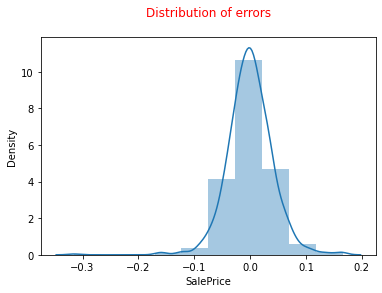

In [55]:
# Plot errors
plt.title('Distribution of errors\n',fontweight=25,color='r')
sns.distplot(res,bins=10)
plt.show()

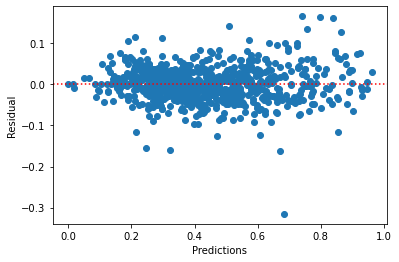

In [56]:
plt.scatter( y_pred_train , res)
plt.axhline(y=0, color='r', linestyle=':')
plt.xlabel("Predictions")
plt.ylabel("Residual")
plt.show()

* Residuals are centered around y = 0

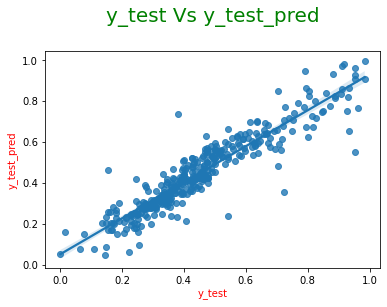

In [57]:
# Plot the y_test, y_test_pred   
sns.regplot(x=y_test,y=y_pred_test)
plt.title('y_test Vs y_test_pred\n',fontsize=20,color='g')
plt.xlabel('y_test',fontsize=10,color='r')
plt.ylabel('y_test_pred',fontsize=10,color='r')
plt.show()

## Ridge regression

In [58]:
# Lambda splits - List of alphas to tune
params = {'alpha':[0.0001, 0.001, 0.01, 0.05, 0.1, 
 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0, 
 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

In [59]:
# Instantiate Rigdge class
ridge = Ridge()

In [60]:
# Perform Cross Validation
folds = 5
model_cv = GridSearchCV(estimator=ridge,
                       param_grid=params,
                       scoring='neg_mean_absolute_error',
                       cv=folds,
                       return_train_score=True,
                       verbose=1)

# Fit the train dataset
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [61]:
# display hyperparams
print (model_cv.best_params_)

{'alpha': 3.0}


In [62]:
# Choose alpha as 3 
ridge = Ridge(alpha=3)

# Fit train dataset
ridge.fit(X_train, y_train)

Ridge(alpha=3)

In [63]:
# Co-efficients
print (ridge.coef_)

[ 2.78530385e-02  8.25636488e-02  5.07402360e-04  5.91921105e-05
  1.09742565e-01  9.23154699e-03 -1.04280864e-02  1.92899110e-01
  6.43297326e-02  7.92792896e-05  3.06065173e-02  3.57482687e-02
 -5.85198184e-03 -3.15647542e-02  2.97321475e-03  2.58907894e-02
  4.19817412e-05  1.22925361e-02  4.62861467e-02  2.64993035e-02
  1.55535291e-02  1.00547784e-05 -8.35569502e-03  2.79295642e-02
  2.31525911e-02  1.49090321e-02 -5.78369710e-02 -3.14209648e-02
  2.61962852e-02 -1.15175489e-02  2.45530381e-03 -2.17593240e-03
  6.35678843e-03  8.93507560e-03  1.00084907e-02  8.11884274e-03
  2.70146943e-02  1.05350029e-02 -1.08924679e-02 -5.76115492e-03
 -1.13530343e-02  5.08855053e-02  3.88709874e-03  1.72180817e-02
 -2.68260973e-03  1.65172564e-02 -5.68418990e-03  1.53607007e-02
 -1.25595899e-02 -1.44869928e-02 -2.52141774e-03 -2.40761353e-02
 -2.59021556e-02 -1.12426895e-04 -1.45634946e-02  6.68127408e-03
 -1.86023348e-02 -7.83888197e-03 -6.16972758e-03  1.70277106e-02
 -2.11272873e-02  2.54913

In [64]:
# Predict on train dataset
y_train_pred = ridge.predict(X_train)
y_test_pred  = ridge.predict(X_test)

In [65]:
# Determine metrics for the ridge regression

# Create an empty list
metrics2 = []

#R2 score for train
r2_train_lr = r2_score(y_train, y_train_pred)
metrics2.append(r2_train_lr)

# r2 score for test
r2_test_lr = r2_score(y_test, y_test_pred)
metrics2.append(r2_test_lr)

# Residual sum of squares for train dataset
rss_train_lr = np.sum(np.square(y_train - y_train_pred))
metrics2.append(rss_train_lr)

# RSS for test dataset
rss_test_lr = np.sum(np.square(y_test - y_test_pred))
metrics2.append(rss_test_lr)

# Mean squared error for train
mse_train_lr = mean_squared_error(y_train, y_train_pred)
metrics2.append(mse_train_lr)

rmse_train_lr = mse_train_lr ** 0.5
metrics2.append(rmse_train_lr)

# Mean squared error for test
mse_test_lr = mean_squared_error(y_test, y_test_pred)
metrics2.append(mse_test_lr)

rmse_test_lr = mse_test_lr ** 0.5
metrics2.append(rmse_test_lr)

In [66]:
# Determine residuals
res = y_train - y_train_pred

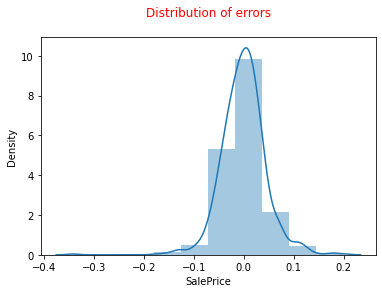

In [67]:
# Plot errors
plt.title('Distribution of errors\n',fontweight=25,color='r')
sns.distplot(res,bins=10)
plt.show()

* Residuals are centered around y = 0

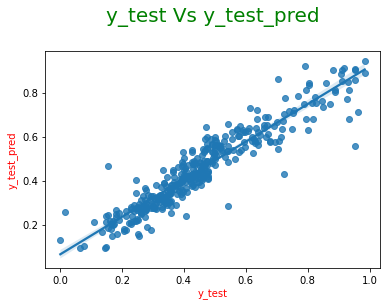

In [68]:
# Plot the y_test, y_test_pred   
sns.regplot(x=y_test,y=y_test_pred)
plt.title('y_test Vs y_test_pred\n',fontsize=20,color='g')
plt.xlabel('y_test',fontsize=10,color='r')
plt.ylabel('y_test_pred',fontsize=10,color='r')
plt.show()

## Lasso Regression

In [69]:
# Instantiate Class
lasso = Lasso()

# Cross Validation
model_cv = GridSearchCV(estimator=lasso,
                       param_grid=params,
                       cv=folds,
                       scoring='neg_mean_absolute_error',
                       return_train_score=True,
                       verbose=1)

# Fit the model
model_cv.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits


GridSearchCV(cv=5, estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3,
                                   0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0, 3.0,
                                   4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50,
                                   100, 500, 1000]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

In [70]:
# Print hyperparams
print (model_cv.best_params_)

{'alpha': 0.0001}


In [71]:
# Fitting lasso with aplha 
lasso = Lasso(alpha=0.0001)

lasso.fit(X_train, y_train)

Lasso(alpha=0.0001)

In [72]:
# Print the co-efficients
lasso.coef_

array([ 1.39021360e-02,  8.05664814e-02,  4.51581855e-04,  2.61003845e-05,
        1.12339148e-01,  2.53828182e-03, -5.74816603e-03,  2.99835536e-01,
        6.84960277e-02,  0.00000000e+00,  2.02828650e-02,  2.70395080e-02,
       -8.17525752e-03, -7.95443087e-02, -8.07524182e-04,  2.80367422e-02,
        1.58749063e-05,  7.86403626e-03,  4.61375637e-02,  2.74995243e-02,
        1.40083894e-02,  3.33651149e-05, -0.00000000e+00,  3.11529956e-02,
        0.00000000e+00,  1.35203206e-03, -1.15318689e-01, -4.05844472e-02,
        0.00000000e+00, -1.73673210e-02,  0.00000000e+00,  0.00000000e+00,
       -0.00000000e+00,  1.14058105e-02,  6.39962543e-03, -0.00000000e+00,
        1.38487509e-02,  0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -1.99832678e-02,  6.11195097e-02,  0.00000000e+00,  1.62117130e-02,
        0.00000000e+00,  0.00000000e+00, -8.14558754e-04,  5.01474319e-03,
       -9.65782632e-03, -8.02937544e-03, -0.00000000e+00, -2.58521892e-02,
       -2.29247104e-02, -

In [73]:
# Predict train and test
y_train_pred = lasso.predict(X_train)
y_test_pred  = lasso.predict(X_test)

In [74]:
# Create metrics for lasso regression
metrics3 = []

#R2 score for train
r2_train_lr = r2_score(y_train, y_train_pred)
metrics3.append(r2_train_lr)

# r2 score for test
r2_test_lr = r2_score(y_test, y_test_pred)
metrics3.append(r2_test_lr)

# Residual sum of squares for train dataset
rss_train_lr = np.sum(np.square(y_train - y_train_pred))
metrics3.append(rss_train_lr)

# RSS for test dataset
rss_test_lr = np.sum(np.square(y_test - y_test_pred))
metrics3.append(rss_test_lr)

# Mean squared error for train
mse_train_lr = mean_squared_error(y_train, y_train_pred)
metrics3.append(mse_train_lr)

rmse_train_lr = mse_train_lr ** 0.5
metrics3.append(rmse_train_lr)

# Mean squared error for test
mse_test_lr = mean_squared_error(y_test, y_test_pred)
metrics3.append(mse_test_lr)

rmse_test_lr = mse_test_lr ** 0.5
metrics3.append(rmse_test_lr)

In [75]:
# Determine residuals
res = y_train - y_train_pred

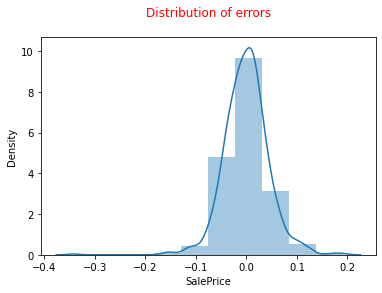

In [76]:
# Plot errors
plt.title('Distribution of errors\n',fontweight=25,color='r')
sns.distplot(res,bins=10)
plt.show()

* Residuals are centered around y = 0

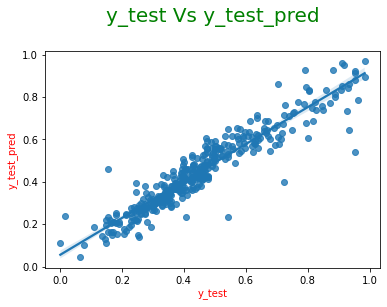

In [77]:
# Plot the y_test, y_test_pred   
sns.regplot(x=y_test,y=y_test_pred)
plt.title('y_test Vs y_test_pred\n',fontsize=20,color='g')
plt.xlabel('y_test',fontsize=10,color='r')
plt.ylabel('y_test_pred',fontsize=10,color='r')
plt.show()

In [78]:
# Tabulate metrics from all regression models
reg_table = {'Metrics':['R2_Score_train','R2_Score_test','RSS_Train','RSS_Test','MSE_train','MSE_test','RMSE_Train','RMSE_test'], 'Linear Regression': metric}

# Create a dataframe for LR table
lr_metric = pd.DataFrame(reg_table, columns=['Metrics','Linear Regression'])

# create series object
rg_metric = pd.Series(metrics2, name='Ridge Reg')
ls_metric = pd.Series(metrics3, name='Lasso Reg')

# Concatenate all metrics
metrics = pd.concat([lr_metric, rg_metric, ls_metric],axis=1)

#Print the metrics
metrics

Metrics  Linear Regression  Ridge Reg  Lasso Reg
0  R2_Score_train           0.951940   0.943248   0.943861
1   R2_Score_test           0.858770   0.875869   0.883196
2       RSS_Train           1.428246   1.686547   1.668332
3        RSS_Test           2.009493   1.766211   1.661955
4       MSE_train           0.001670   0.001973   0.001951
5        MSE_test           0.005475   0.044414   0.044173
6      RMSE_Train           0.040871   0.004813   0.004528
7       RMSE_test           0.073996   0.069373   0.067294

### Changes in co-efficients after regularization

In [79]:
# Create a datafram with required cols
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_

In [80]:
betas.sort_values(by='Lasso',ascending=False)

Linear     Ridge     Lasso
GrLivArea               0.309121  0.192899  0.299836
OverallQual_Excellent   0.168539  0.103781  0.174053
TotalBsmtSF             0.116734  0.109743  0.112339
OverallQual_VGood       0.089805  0.091612  0.101698
OverallQual_VExcellent  0.114742  0.034286  0.091964
...                          ...       ...       ...
KitchenQual_Gd         -0.058160 -0.048931 -0.054758
KitchenQual_TA         -0.061167 -0.055515 -0.060636
KitchenQual_Fa         -0.070834 -0.056159 -0.064822
KitchenAbvGr           -0.102905 -0.031565 -0.079544
Age                    -0.141546 -0.057837 -0.115319

[281 rows x 3 columns]

In [81]:
pd.set_option('display.max_rows', None)
betas.sort_values(by='Ridge',ascending=False)

Linear     Ridge     Lasso
GrLivArea                 3.091214e-01  0.192899  0.299836
TotalBsmtSF               1.167342e-01  0.109743  0.112339
OverallQual_Excellent     1.685393e-01  0.103781  0.174053
OverallQual_VGood         8.980535e-02  0.091612  0.101698
LotArea                   8.108273e-02  0.082564  0.080566
Neighborhood_Crawfor      9.414744e-02  0.065637  0.078253
BsmtFullBath              7.241405e-02  0.064330  0.068496
Neighborhood_NoRidge      8.281503e-02  0.062471  0.062979
OverallCond_Excellent     7.649928e-02  0.055148  0.067775
MSZoning_FV               2.088808e-01  0.050886  0.061120
GarageArea                4.444289e-02  0.046286  0.046138
GarageType_BuiltIn        1.499444e-01  0.038164  0.023566
Exterior1st_BrkFace       3.160283e-02  0.037423  0.048849
MasVnrType_Stone          7.167063e-02  0.036760  0.021387
HalfBath                  3.398115e-02  0.035748  0.027040
SaleType_Con              9.226578e-02  0.034308  0.040614
OverallQual_VExcellent    1.147421e-01  0.034286  0.091964
Condition1_PosA           6.500669e-02  0.033867  0.012460
Neighborhood_StoneBr      6.189427e-02  0.033001  0.024327
OverallQual_Good          3.476578e-02  0.032198  0.035526
BsmtExposure_Gd           2.728561e-02  0.030815  0.033518
FullBath                  2.544180e-02  0.030607  0.020283
Exterior1st_Stone         8.506018e-02  0.030456  0.039407
SaleCondition_Partial     1.021009e-01  0.028947  0.031460
Condition1_Norm           4.823165e-02  0.028713  0.021129
Condition1_PosN           5.543974e-02  0.028564  0.017625
ScreenPorch               3.268312e-02  0.027930  0.031153
LotFrontage               3.123319e-02  0.027853  0.013902
Condition1_RRNn           8.608257e-02  0.027145  0.007033
MSSubClass_70            -6.961090e-04  0.027015  0.013849
WoodDeckSF                3.418500e-02  0.026499  0.027500
MSSubClass_180            5.562346e-02  0.026196  0.000000
Fireplaces                2.342048e-02  0.025891  0.028037
SaleCondition_Normal      2.760626e-02  0.025805  0.027837
OverallCond_VGood         3.326613e-02  0.025503  0.029550
Neighborhood_BrkSide      5.827883e-02  0.025491  0.031650
Functional_Typ            3.693538e-02  0.025064  0.032862
RoofMatl_WdShake          5.625391e-02  0.024878  0.027003
BsmtCond_Gd               1.868717e-02  0.024559  0.023022
Foundation_PConc          1.798112e-02  0.023719  0.014141
PoolArea                  4.550322e-02  0.023153  0.000000
Foundation_Slab           2.155096e-02  0.023139  0.000000
Condition2_Norm           7.274027e-02  0.021030  0.006490
Neighborhood_NridgHt      3.315682e-02  0.019868  0.018813
BsmtCond_TA               1.549077e-02  0.019112  0.020215
MSZoning_RL               1.367561e-01  0.017218  0.016212
MasVnrType_BrkFace        5.253536e-02  0.017214  0.005073
LandSlope_Mod             1.981040e-02  0.017028  0.014539
Condition2_RRNn           1.127807e-01  0.016953  0.000000
Fence_No Fence            2.184887e-02  0.016857  0.011595
Street_Pave               1.085789e-02  0.016517  0.000000
SaleType_ConLD            2.635082e-02  0.016508  0.008709
OverallCond_Good          2.038216e-02  0.016394  0.018929
SaleCondition_AdjLand     3.532361e-02  0.016353  0.017106
Fence_MnPrv               2.325650e-02  0.015817  0.010296
OpenPorchSF               1.419130e-02  0.015554  0.014008
Alley_Pave                6.190358e-03  0.015361  0.005015
MiscVal                   6.300659e-02  0.014909  0.001352
GarageType_Attchd         1.261549e-01  0.013923  0.005597
GarageType_Detchd         1.298501e-01  0.013778  0.007989
Exterior2nd_CmentBd       1.323115e-02  0.013602  0.004817
Exterior1st_CemntBd       1.323115e-02  0.013602  0.014167
Functional_Min1           2.751547e-02  0.013503  0.010425
Neighborhood_NPkVill      5.911510e-02  0.013161  0.000000
Heating_Wall              1.436355e-01  0.012803  0.000000
GarageCars                1.265660e-02  0.012293  0.007864
Condition1_RRAn           4.425685e-02  0.012259  0.005848
BsmtFinType1_GLQ    

In [82]:
pd.set_option('display.max_rows', None)
betas.sort_values(by='Lasso',ascending=False)

Linear     Ridge     Lasso
GrLivArea                 3.091214e-01  0.192899  0.299836
OverallQual_Excellent     1.685393e-01  0.103781  0.174053
TotalBsmtSF               1.167342e-01  0.109743  0.112339
OverallQual_VGood         8.980535e-02  0.091612  0.101698
OverallQual_VExcellent    1.147421e-01  0.034286  0.091964
LotArea                   8.108273e-02  0.082564  0.080566
Neighborhood_Crawfor      9.414744e-02  0.065637  0.078253
BsmtFullBath              7.241405e-02  0.064330  0.068496
OverallCond_Excellent     7.649928e-02  0.055148  0.067775
Neighborhood_NoRidge      8.281503e-02  0.062471  0.062979
MSZoning_FV               2.088808e-01  0.050886  0.061120
Exterior1st_BrkFace       3.160283e-02  0.037423  0.048849
GarageArea                4.444289e-02  0.046286  0.046138
SaleType_Con              9.226578e-02  0.034308  0.040614
Exterior1st_Stone         8.506018e-02  0.030456  0.039407
OverallQual_Good          3.476578e-02  0.032198  0.035526
BsmtExposure_Gd           2.728561e-02  0.030815  0.033518
Functional_Typ            3.693538e-02  0.025064  0.032862
Neighborhood_BrkSide      5.827883e-02  0.025491  0.031650
SaleCondition_Partial     1.021009e-01  0.028947  0.031460
ScreenPorch               3.268312e-02  0.027930  0.031153
OverallCond_VGood         3.326613e-02  0.025503  0.029550
Fireplaces                2.342048e-02  0.025891  0.028037
SaleCondition_Normal      2.760626e-02  0.025805  0.027837
WoodDeckSF                3.418500e-02  0.026499  0.027500
HalfBath                  3.398115e-02  0.035748  0.027040
RoofMatl_WdShake          5.625391e-02  0.024878  0.027003
Neighborhood_StoneBr      6.189427e-02  0.033001  0.024327
GarageType_BuiltIn        1.499444e-01  0.038164  0.023566
BsmtCond_Gd               1.868717e-02  0.024559  0.023022
MasVnrType_Stone          7.167063e-02  0.036760  0.021387
Condition1_Norm           4.823165e-02  0.028713  0.021129
FullBath                  2.544180e-02  0.030607  0.020283
BsmtCond_TA               1.549077e-02  0.019112  0.020215
OverallCond_Good          2.038216e-02  0.016394  0.018929
Neighborhood_NridgHt      3.315682e-02  0.019868  0.018813
Condition1_PosN           5.543974e-02  0.028564  0.017625
SaleCondition_AdjLand     3.532361e-02  0.016353  0.017106
MSZoning_RL               1.367561e-01  0.017218  0.016212
LandSlope_Mod             1.981040e-02  0.017028  0.014539
Exterior1st_CemntBd       1.323115e-02  0.013602  0.014167
Foundation_PConc          1.798112e-02  0.023719  0.014141
Heating_GasA              9.322806e-02  0.011744  0.014136
OpenPorchSF               1.419130e-02  0.015554  0.014008
LotFrontage               3.123319e-02  0.027853  0.013902
MSSubClass_70            -6.961090e-04  0.027015  0.013849
Condition1_PosA           6.500669e-02  0.033867  0.012460
Fence_No Fence            2.184887e-02  0.016857  0.011595
MSSubClass_45            -7.916963e-02  0.008935  0.011406
BsmtFinType1_GLQ          1.137585e-02  0.011803  0.010842
Functional_Min1           2.751547e-02  0.013503  0.010425
Fence_MnPrv               2.325650e-02  0.015817  0.010296
SaleType_ConLD            2.635082e-02  0.016508  0.008709
BsmtFinType2_LwQ          3.140572e-03  0.010974  0.008119
GarageType_Detchd         1.298501e-01  0.013778  0.007989
GarageCars                1.265660e-02  0.012293  0.007864
LotConfig_CulDSac         4.958768e-03  0.006681  0.007733
BsmtFinType2_Unf          4.694999e-03  0.004177  0.007250
Condition1_RRNn           8.608257e-02  0.027145  0.007033
Condition2_Norm           7.274027e-02  0.021030  0.006490
MSSubClass_50            -2.507787e-02  0.010008  0.006400
Neighborhood_SawyerW      3.160631e-02  0.008390  0.006283
Condition1_RRAn           4.425685e-02  0.012259  0.005848
GarageType_Attchd         1.261549e-01  0.013923  0.005597
Foundation_CBlock         1.365590e-02  0.011080  0.005422
MasVnrType_BrkFace        5.253536e-02  0.017214  0.005073
Alley_Pave                6.190358e-03  0.015361  0.005015
Exterior1st_MetalSd 

# Final Observations 

### Determine the significant variables in predicting the price of a house
 
Linear regression performs well on the train dataset but not on the test dataset.
Based on the metrics table for Linear, Ridge and Lasso regression - Lasso Regression has a good R2 score for both Test and Train datasets as compared to Ridge regression.

The significant variables in predicting the price of the house are 
   1. GrLivArea
   2. OverallQual_Excellent
   3. TotalBsmtSF
   4. OverallQual_VGood
   5. OverallQual_VExcellent
   6. LotArea
   7. Neighborhood_Crawfor
   8. BsmtFullBath
   9. OverallCond_Excellent
   10. Neighborhood_NoRidge

### How those variables describe the price of a house

   1. House price increase by 0.299 if there is an increase in 1 SF of ground living area
   2. OverallQual_Excellent - when the house overall quality is excellent - Price increases by 0.17 times
   3. TotalBsmtSF - Price increases by 0.11 for 1 SF increase
   4. OverallQual_VGood - When the house overall quality is in very good condition price increases by 0.10
   5. OverallQual_VExcellent - When the house overall quality is very excellent condition price increases by 0.09
   6. LotArea - Price increases by 0.08 for per SF increase
   7. Neighborhood_Crawfor - When the house is in neighbourhood Crawfor - price increases by 0.07
   8. BsmtFullBath - When house has basement with full bath, price increases by 0.068
   9. OverallCond_Excellent - When the house overall cond is excellent n price increases by 0.067
   10. Neighborhood_NoRidge - When the house is in neighbourhood Crawfor - price increases by 0.062

### Determine the optimal value of lambda for Ridge and Lasso regression.

* Optimal value for Lambda - Ridge regression is 3 
* Optimal value for Lambda - Lasso regression is 0.0001

# Subjective questions

### Double alpha for Ridge

In [83]:
rigde = Ridge(alpha=6)

# Fit train dataset
ridge.fit(X_train, y_train)

# Predict train and test
y_train_pred = ridge.predict(X_train)
y_test_pred  = ridge.predict(X_test)

# Determine metrics for the ridge regression

# Create an empty list
metrics2 = []

#R2 score for train
r2_train_lr = r2_score(y_train, y_train_pred)
metrics2.append(r2_train_lr)

# r2 score for test
r2_test_lr = r2_score(y_test, y_test_pred)
metrics2.append(r2_test_lr)

# Residual sum of squares for train dataset
rss_train_lr = np.sum(np.square(y_train - y_train_pred))
metrics2.append(rss_train_lr)

# RSS for test dataset
rss_test_lr = np.sum(np.square(y_test - y_test_pred))
metrics2.append(rss_test_lr)

# Mean squared error for train
mse_train_lr = mean_squared_error(y_train, y_train_pred)
metrics2.append(mse_train_lr)

rmse_train_lr = mse_train_lr ** 0.5
metrics2.append(rmse_train_lr)

# Mean squared error for test
mse_test_lr = mean_squared_error(y_test, y_test_pred)
metrics2.append(mse_test_lr)

rmse_test_lr = mse_test_lr ** 0.5
metrics2.append(rmse_test_lr)

### Double Alpha for Lasso

In [84]:
lasso = Lasso(alpha=0.0002)

# Fit lasso
lasso.fit(X_train,y_train)


# Predict train and test
y_train_pred = lasso.predict(X_train)
y_test_pred  = lasso.predict(X_test)
# Create metrics for lasso regression
metrics3 = []

#R2 score for train
r2_train_lr = r2_score(y_train, y_train_pred)
metrics3.append(r2_train_lr)

# r2 score for test
r2_test_lr = r2_score(y_test, y_test_pred)
metrics3.append(r2_test_lr)

# Residual sum of squares for train dataset
rss_train_lr = np.sum(np.square(y_train - y_train_pred))
metrics3.append(rss_train_lr)

# RSS for test dataset
rss_test_lr = np.sum(np.square(y_test - y_test_pred))
metrics3.append(rss_test_lr)

# Mean squared error for train
mse_train_lr = mean_squared_error(y_train, y_train_pred)
metrics3.append(mse_train_lr)

rmse_train_lr = mse_train_lr ** 0.5
metrics3.append(rmse_train_lr)

# Mean squared error for test
mse_test_lr = mean_squared_error(y_test, y_test_pred)
metrics3.append(mse_test_lr)

rmse_test_lr = mse_test_lr ** 0.5
metrics3.append(rmse_test_lr)

In [85]:
# Tabulate metrics from all regression models
reg_table = {'Metrics':['R2_Score_train','R2_Score_test','RSS_Train','RSS_Test','MSE_train','MSE_test','RMSE_Train','RMSE_test'], 'Linear Regression': metric}

# Create a dataframe for LR table
lr_metric = pd.DataFrame(reg_table, columns=['Metrics','Linear Regression'])

# create series object
rg_metric = pd.Series(metrics2, name='Ridge Reg')
ls_metric = pd.Series(metrics3, name='Lasso Reg')

# Concatenate all metrics
metrics = pd.concat([lr_metric, rg_metric, ls_metric],axis=1)

#Print the metrics
metrics

Metrics  Linear Regression  Ridge Reg  Lasso Reg
0  R2_Score_train           0.951940   0.943248   0.937911
1   R2_Score_test           0.858770   0.875869   0.881887
2       RSS_Train           1.428246   1.686547   1.845163
3        RSS_Test           2.009493   1.766211   1.680576
4       MSE_train           0.001670   0.001973   0.002158
5        MSE_test           0.005475   0.044414   0.046455
6      RMSE_Train           0.040871   0.004813   0.004579
7       RMSE_test           0.073996   0.069373   0.067670

In [86]:
# Create a datafram with required cols
betas = pd.DataFrame(index=X_train.columns)
betas.rows = X_train.columns

betas['Linear'] = lm.coef_
betas['Ridge'] = ridge.coef_
betas['Lasso'] = lasso.coef_
betas.head()

Linear     Ridge     Lasso
LotFrontage   0.031233  0.027853  0.012758
LotArea       0.081083  0.082564  0.080008
YearRemodAdd  0.000356  0.000507  0.000540
MasVnrArea    0.000028  0.000059  0.000037
TotalBsmtSF   0.116734  0.109743  0.113141

In [87]:
betas.sort_values(by='Lasso',ascending=False)

Linear     Ridge     Lasso
GrLivArea                 3.091214e-01  0.192899  0.296223
OverallQual_Excellent     1.685393e-01  0.103781  0.169563
TotalBsmtSF               1.167342e-01  0.109743  0.113141
OverallQual_VGood         8.980535e-02  0.091612  0.107551
LotArea                   8.108273e-02  0.082564  0.080008
Neighborhood_Crawfor      9.414744e-02  0.065637  0.079880
BsmtFullBath              7.241405e-02  0.064330  0.067106
OverallQual_VExcellent    1.147421e-01  0.034286  0.061989
MSZoning_FV               2.088808e-01  0.050886  0.057507
OverallCond_Excellent     7.649928e-02  0.055148  0.055849
Neighborhood_NoRidge      8.281503e-02  0.062471  0.055572
Exterior1st_BrkFace       3.160283e-02  0.037423  0.046828
GarageArea                4.444289e-02  0.046286  0.044095
OverallQual_Good          3.476578e-02  0.032198  0.036501
Functional_Typ            3.693538e-02  0.025064  0.032876
BsmtExposure_Gd           2.728561e-02  0.030815  0.032343
Neighborhood_BrkSide      5.827883e-02  0.025491  0.031130
SaleCondition_Partial     1.021009e-01  0.028947  0.028610
ScreenPorch               3.268312e-02  0.027930  0.027048
SaleCondition_Normal      2.760626e-02  0.025805  0.025843
OverallCond_VGood         3.326613e-02  0.025503  0.025646
BsmtCond_Gd               1.868717e-02  0.024559  0.025630
WoodDeckSF                3.418500e-02  0.026499  0.024653
BsmtCond_TA               1.549077e-02  0.019112  0.023978
Fireplaces                2.342048e-02  0.025891  0.020929
HalfBath                  3.398115e-02  0.035748  0.020886
MasVnrType_Stone          7.167063e-02  0.036760  0.020284
FullBath                  2.544180e-02  0.030607  0.018701
Condition1_Norm           4.823165e-02  0.028713  0.017530
OverallCond_Good          2.038216e-02  0.016394  0.017212
MSZoning_RL               1.367561e-01  0.017218  0.015011
Neighborhood_NridgHt      3.315682e-02  0.019868  0.014621
OpenPorchSF               1.419130e-02  0.015554  0.013979
Exterior1st_CemntBd       1.323115e-02  0.013602  0.013651
GarageType_BuiltIn        1.499444e-01  0.038164  0.013375
BsmtFinType1_GLQ          1.137585e-02  0.011803  0.012890
LotFrontage               3.123319e-02  0.027853  0.012758
Foundation_PConc          1.798112e-02  0.023719  0.012673
GarageCars                1.265660e-02  0.012293  0.009341
LotConfig_CulDSac         4.958768e-03  0.006681  0.009313
BsmtFinType2_LwQ          3.140572e-03  0.010974  0.008994
Heating_GasA              9.322806e-02  0.011744  0.008593
Fence_No Fence            2.184887e-02  0.016857  0.007742
CentralAir               -6.930345e-03  0.009232  0.005999
LandSlope_Mod             1.981040e-02  0.017028  0.005833
BsmtFinType2_Unf          4.694999e-03  0.004177  0.005378
Exterior2nd_CmentBd       1.323115e-02  0.013602  0.005026
Fence_MnPrv               2.325650e-02  0.015817  0.004845
Exterior1st_Stone         8.506018e-02  0.030456  0.004837
MSSubClass_70            -6.961090e-04  0.027015  0.004607
Exterior1st_MetalSd       4.485869e-03  0.000946  0.004128
ExterCond_TA             -2.410768e-02 -0.000808  0.003864
Foundation_CBlock         1.365590e-02  0.011080  0.003342
MSSubClass_50            -2.507787e-02  0.010008  0.002860
FireplaceQu_TA            2.085057e-02  0.002327  0.002387
MasVnrType_BrkFace        5.253536e-02  0.017214  0.002292
Functional_Min1           2.751547e-02  0.013503  0.002192
GarageCond_TA            -2.060221e-02  0.002776  0.001866
Neighborhood_StoneBr      6.189427e-02  0.033001  0.001597
PavedDrive_Y             -3.455176e-03  0.007115  0.001351
GarageQual_TA            -2.506673e-02 -0.006631  0.001252
MoSold_May               -1.980355e-03  0.001062  0.001114
GarageType_Detchd         1.298501e-01  0.013778  0.001023
MoSold_Aug                4.351769e-04  0.004712  0.000653
YearRemodAdd              3.558436e-04  0.000507  0.000540
MasVnrArea                2.832614e-05  0.000059  0.000037
EnclosedPorch             2.989248e-05  0.000010  0.000036
Heating_Grav        

In [88]:
betas.sort_values(by='Ridge',ascending=False)

Linear     Ridge     Lasso
GrLivArea                 3.091214e-01  0.192899  0.296223
TotalBsmtSF               1.167342e-01  0.109743  0.113141
OverallQual_Excellent     1.685393e-01  0.103781  0.169563
OverallQual_VGood         8.980535e-02  0.091612  0.107551
LotArea                   8.108273e-02  0.082564  0.080008
Neighborhood_Crawfor      9.414744e-02  0.065637  0.079880
BsmtFullBath              7.241405e-02  0.064330  0.067106
Neighborhood_NoRidge      8.281503e-02  0.062471  0.055572
OverallCond_Excellent     7.649928e-02  0.055148  0.055849
MSZoning_FV               2.088808e-01  0.050886  0.057507
GarageArea                4.444289e-02  0.046286  0.044095
GarageType_BuiltIn        1.499444e-01  0.038164  0.013375
Exterior1st_BrkFace       3.160283e-02  0.037423  0.046828
MasVnrType_Stone          7.167063e-02  0.036760  0.020284
HalfBath                  3.398115e-02  0.035748  0.020886
SaleType_Con              9.226578e-02  0.034308  0.000000
OverallQual_VExcellent    1.147421e-01  0.034286  0.061989
Condition1_PosA           6.500669e-02  0.033867  0.000000
Neighborhood_StoneBr      6.189427e-02  0.033001  0.001597
OverallQual_Good          3.476578e-02  0.032198  0.036501
BsmtExposure_Gd           2.728561e-02  0.030815  0.032343
FullBath                  2.544180e-02  0.030607  0.018701
Exterior1st_Stone         8.506018e-02  0.030456  0.004837
SaleCondition_Partial     1.021009e-01  0.028947  0.028610
Condition1_Norm           4.823165e-02  0.028713  0.017530
Condition1_PosN           5.543974e-02  0.028564  0.000000
ScreenPorch               3.268312e-02  0.027930  0.027048
LotFrontage               3.123319e-02  0.027853  0.012758
Condition1_RRNn           8.608257e-02  0.027145  0.000000
MSSubClass_70            -6.961090e-04  0.027015  0.004607
WoodDeckSF                3.418500e-02  0.026499  0.024653
MSSubClass_180            5.562346e-02  0.026196  0.000000
Fireplaces                2.342048e-02  0.025891  0.020929
SaleCondition_Normal      2.760626e-02  0.025805  0.025843
OverallCond_VGood         3.326613e-02  0.025503  0.025646
Neighborhood_BrkSide      5.827883e-02  0.025491  0.031130
Functional_Typ            3.693538e-02  0.025064  0.032876
RoofMatl_WdShake          5.625391e-02  0.024878  0.000000
BsmtCond_Gd               1.868717e-02  0.024559  0.025630
Foundation_PConc          1.798112e-02  0.023719  0.012673
PoolArea                  4.550322e-02  0.023153  0.000000
Foundation_Slab           2.155096e-02  0.023139 -0.000000
Condition2_Norm           7.274027e-02  0.021030  0.000000
Neighborhood_NridgHt      3.315682e-02  0.019868  0.014621
BsmtCond_TA               1.549077e-02  0.019112  0.023978
MSZoning_RL               1.367561e-01  0.017218  0.015011
MasVnrType_BrkFace        5.253536e-02  0.017214  0.002292
LandSlope_Mod             1.981040e-02  0.017028  0.005833
Condition2_RRNn           1.127807e-01  0.016953  0.000000
Fence_No Fence            2.184887e-02  0.016857  0.007742
Street_Pave               1.085789e-02  0.016517  0.000000
SaleType_ConLD            2.635082e-02  0.016508  0.000000
OverallCond_Good          2.038216e-02  0.016394  0.017212
SaleCondition_AdjLand     3.532361e-02  0.016353  0.000000
Fence_MnPrv               2.325650e-02  0.015817  0.004845
OpenPorchSF               1.419130e-02  0.015554  0.013979
Alley_Pave                6.190358e-03  0.015361  0.000000
MiscVal                   6.300659e-02  0.014909  0.000000
GarageType_Attchd         1.261549e-01  0.013923  0.000000
GarageType_Detchd         1.298501e-01  0.013778  0.001023
Exterior2nd_CmentBd       1.323115e-02  0.013602  0.005026
Exterior1st_CemntBd       1.323115e-02  0.013602  0.013651
Functional_Min1           2.751547e-02  0.013503  0.002192
Neighborhood_NPkVill      5.911510e-02  0.013161  0.000000
Heating_Wall              1.436355e-01  0.012803  0.000000
GarageCars                1.265660e-02  0.012293  0.009341
Condition1_RRAn           4.425685e-02  0.012259  0.000000
BsmtFinType1_GLQ    

## Question 3


After building the model, you realised that the five most important predictor variables in the lasso model are not available in the incoming data. You will now have to create another model excluding the five most important predictor variables. Which are the five most important predictor variables now?


Dropping the top five variables of Lasso from train and test datasets 
* GrLivArea
* OverallQual_Excellent
* TotalBsmtSF
* OverallQual_VGood
* OverallQual_VExcellent

In [89]:
# Drop the top five predictors from X_train and X_test
X_train.drop(['GrLivArea','OverallQual_Excellent','TotalBsmtSF','OverallQual_VExcellent','OverallQual_VGood'],axis=1,inplace=True)
X_test.drop(['GrLivArea','OverallQual_Excellent','TotalBsmtSF','OverallQual_VExcellent','OverallQual_VGood'],axis=1,inplace=True)

# Instantiate a class of Lasso regression
lasso = Lasso(alpha=0.0002)

# Fit lasso
lasso.fit(X_train,y_train)


# Predict train and test
y_train_pred = lasso.predict(X_train)
y_test_pred  = lasso.predict(X_test)
# Create metrics for lasso regression
metrics3 = []

#R2 score for train
r2_train_lr = r2_score(y_train, y_train_pred)
metrics3.append(r2_train_lr)

# r2 score for test
r2_test_lr = r2_score(y_test, y_test_pred)
metrics3.append(r2_test_lr)

# Residual sum of squares for train dataset
rss_train_lr = np.sum(np.square(y_train - y_train_pred))
metrics3.append(rss_train_lr)

# RSS for test dataset
rss_test_lr = np.sum(np.square(y_test - y_test_pred))
metrics3.append(rss_test_lr)

# Mean squared error for train
mse_train_lr = mean_squared_error(y_train, y_train_pred)
metrics3.append(mse_train_lr)

rmse_train_lr = mse_train_lr ** 0.5
metrics3.append(rmse_train_lr)

# Mean squared error for test
mse_test_lr = mean_squared_error(y_test, y_test_pred)
metrics3.append(mse_test_lr)

rmse_test_lr = mse_test_lr ** 0.5
metrics3.append(rmse_test_lr)

In [90]:
# Create a datafram with required cols
l_betas = pd.DataFrame(index=X_train.columns)
l_betas.rows = X_train.columns

l_betas['Lasso'] = lasso.coef_
l_betas.head()

Lasso
LotFrontage   0.039618
LotArea       0.113787
YearRemodAdd  0.000602
MasVnrArea    0.000115
CentralAir    0.006556

In [91]:
# Sort by descending values of significant variables
l_betas.sort_values(by='Lasso',ascending=False)

Lasso
Neighborhood_NoRidge      0.119998
LotArea                   0.113787
GarageArea                0.103488
Neighborhood_StoneBr      0.100675
Neighborhood_Crawfor      0.081740
BsmtFullBath              0.074998
OverallCond_Excellent     0.072601
Exterior1st_BrkFace       0.064698
FullBath                  0.056610
Fireplaces                0.052794
HalfBath                  0.050684
BsmtExposure_Gd           0.045114
SaleType_Con              0.043455
GarageType_BuiltIn        0.041390
LotFrontage               0.039618
MasVnrType_Stone          0.039184
BsmtCond_Gd               0.038499
Neighborhood_BrkSide      0.037168
Exterior1st_CemntBd       0.036371
Foundation_PConc          0.034913
ScreenPorch               0.033493
Condition1_PosA           0.032250
MSSubClass_70             0.032232
OpenPorchSF               0.031227
MSZoning_FV               0.025338
BsmtCond_TA               0.024238
OverallCond_VGood         0.024124
SaleCondition_Normal      0.023849
Condition1_Norm           0.020811
Neighborhood_Somerst      0.019245
TotRmsAbvGrd              0.018605
Neighborhood_NridgHt      0.018173
MSSubClass_50             0.017850
WoodDeckSF                0.017766
OverallCond_Good          0.017127
Functional_Typ            0.015708
MSZoning_RL               0.015480
Condition1_PosN           0.015378
LandSlope_Mod             0.014472
SaleCondition_Partial     0.013727
FireplaceQu_TA            0.013325
MasVnrType_BrkFace        0.013091
MSSubClass_75             0.012604
BsmtFinType1_GLQ          0.012526
Foundation_Slab           0.012341
Fence_No Fence            0.012200
Fence_MnPrv               0.011051
MoSold_Dec                0.009779
BsmtFinType2_LwQ          0.009656
Alley_Pave                0.009465
Exterior2nd_MetalSd       0.009326
FireplaceQu_Gd            0.007352
PavedDrive_Y              0.006817
CentralAir                0.006556
Exterior1st_Stone         0.006010
Foundation_CBlock         0.005624
Neighborhood_Timber       0.005554
MSSubClass_20             0.004703
Exterior2nd_CmentBd       0.004458
GarageCond_TA             0.004299
Condition1_RRNn           0.004110
GarageCars                0.003885
GarageType_Attchd         0.002540
RoofMatl_WdShake          0.002501
HouseStyle_2.5Unf         0.000765
YearRemodAdd              0.000602
Condition2_Norm           0.000210
MasVnrArea                0.000115
GarageYrBlt               0.000077
EnclosedPorch             0.000013
MiscFeature_TenC          0.000000
BsmtFinType1_LwQ         -0.000000
BsmtHalfBath             -0.000000
BsmtFinType1_BLQ         -0.000000
SaleType_New             -0.000000
BsmtFinType2_BLQ          0.000000
BsmtFinType1_Rec         -0.000000
BsmtCond_Po              -0.000000
BsmtFinType2_GLQ          0.000000
SaleType_ConLw           -0.000000
BsmtFinType2_Unf          0.000000
Heating_GasA              0.000000
Heating_GasW              0.000000
Heating_Grav             -0.000000
BedroomAbvGr             -0.000000
Foundation_Stone         -0.000000
KitchenAbvGr             -0.000000
SaleCondition_Alloca     -0.000000
Exterior2nd_ImStucc       0.000000
Exterior2nd_Other         0.000000
Exterior2nd_Stone        -0.000000
Exterior2nd_Stucco        0.000000
SaleCondition_Family     -0.000000
Exterior2nd_VinylSd      -0.000000
Exterior2nd_Wd Sdng       0.000000
MasVnrType_None          -0.000000
Foundation_Wood          -0.000000
MSSubClass_90            -0.000000
ExterCond_Fa             -0.000000
ExterCond_Po              0.000000
ExterCond_TA              0.000000
SaleCondition_AdjLand     0.000000
SaleType_Oth              0.000000
Heating_Wall              0.000000
Heating_OthW              0.000000
HeatingQC_Po              0.000000
HeatingQC_Fa             -0.000000
MoSold_Nov                0.000000
MoSold_Oct               -0.000000
GarageQual_Po            -0.000000
GarageQual_TA            -0.000000
GarageCond_Fa            -0.000000
GarageCond_Gd            -0.000000
GarageCond_No Garage      0.000000
Gara